In [1]:
!pip install pyrtools

     |████████████████████████████████| 63 kB 805 kB/s eta 0:00:011
  Created wheel for pyrtools: filename=pyrtools-1.0.0-cp38-cp38-linux_x86_64.whl size=101538 sha256=d667021fa28df684355832edfd9cea4f52f37571274fd29d8b888a462c67fa44
  Stored in directory: /home/raphael/.cache/pip/wheels/90/ce/cc/ad588434eaec676d6092014d07bed0f2862828ca2c2a1c92ce
Successfully built pyrtools


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy import fft
from scipy import signal
from scipy import ndimage
from skimage.color import rgb2gray
import pywt
import pyrtools as pt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

On charge un certain nombre de textures.

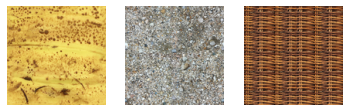

In [5]:
text = plt.imread('banana+peel-128x128.png')
text2 = plt.imread('ground-128x128.png')
text3 = plt.imread('wicker+basket-128x128.png')
textures = [text,text2,text3]
N,N,c = text.shape

fig = plt.figure()

for i,texture in enumerate(textures):
    ax = fig.add_subplot(1,len(textures),i+1)
    ax.axis('off')
    ax.imshow(texture)

**Partie 1 : Projections statistiques**

*Egalisation d'histogramme*

Etant donné deux images en niveau de gris $X$ et $Y$, cette routine renvoie l'image $X_\sigma$ dont l'histogramme est le même que $Y$. C'est à dire :
$$
X_\sigma [i] = X[\sigma(i)]
$$
où $\sigma$ est la permutation qui réalise :
$$
\mathcal{W}^2(X,Y) = \frac{1}{N^2} \sum_i (Y[i]-X[\sigma(i)])^2
$$

In [6]:
# renvoie la projection OT en 1d + la distance OT
def OTproj(x,y):
    assert x.shape==y.shape
    n,m = x.shape
    xf = x.flatten()
    yf = y.flatten()
    sx = np.argsort(xf)
    sy = np.argsort(yf)
    res = np.zeros(n*m)
    res[sx[:]] = yf[sy[:]]
    return res.reshape((n,m)), np.sum((xf[sx]-yf[sy])**2)/(n*m)

*Projection Sliced-Wasserstein*

Etant donné deux images en couleur $X$ et $Y$, de taille $(N,N,3)$, vues comme des mesures de points dans $\mathbb{R}^3$, cette routine renvoie la limite quand $t \rightarrow +\infty$ du flot de gradient $X_t$ définit par :
$$
\frac{dX_t}{dt} = - \nabla^{\mathcal{W}} \mathcal{SW}^2(X_t,Y) , \quad X_0 = X 
$$

L'algorithme procède par descente de gradient stochastique, c'est à dire à chaque itération :
$$
\theta \sim \mathcal{U}(\mathbb{S}^{2}) \\
X_{k+1} = X_k + \epsilon (Y_{\sigma_k} - X_k) \theta
$$
où $\sigma_k$ est la permutation qui réalise :
$$
\mathcal{W}^2(\theta \# X_k, \theta \# Y) = \frac{1}{N^2} \sum_i (\theta \# Y[\sigma_k(i)] - \theta \# X[i])^2
$$

In [43]:
# renvoie la projection SW en dim quelconque + une approximation de la distance SW
def SWproj(x,y,e=0.01):
    assert x.shape==y.shape
    n,m,c=x.shape
    res = x.reshape((-1,c))
    yf = y.reshape((-1,c))
    d = 0
    cond = False
    it = 0
    
    while it < 500 and not cond:
        theta = np.random.randn(c)
        theta = theta/np.linalg.norm(theta)
        rproj = np.dot(res,theta)
        yproj = np.dot(yf,theta)
        sr = np.argsort(rproj)
        sy = np.argsort(yproj)
        grad = np.tensordot((rproj[sr]-yproj[sy]),theta,axes=0)
        res -= e*grad
        d += np.linalg.norm(e*grad)**2
        
        ##condition d'arrêt
        cond = np.linalg.norm(grad)<e
        it += 1
        
    return res.reshape((n,m,c)),d

*Statistique d'ordre 2*

Etant donné une image $X$ avec un seul canal (niveau de gris par exemple), la routine $\texttt{var}$ renvoie une image avec $V$ canaux, dans lesquels sont empilé les valeurs de $X$ dans le voisinage $\texttt{pattern}$ du pixel.

La distribution définit par $\texttt{var}(X)$ contient des informations sur la corrélations entre pixels voisins.

In [8]:
def var(x,pattern):
    res = []
    for u in pattern:
        res.append(ndimage.shift(x,u,mode='wrap'))
    return np.transpose(np.array(res),axes=[1,2,0])

#voisinage 3x3 carré centré
pattern = np.array([[(i,j) for i in range(-1,2)] for j in range(-1,2)]).reshape((-1,2))

**Partie 2 : Décomposition multi-échelle**

On utilise les packages $\texttt{Pyrtools}$ pour la décomposition "steerable-pyramid" et $\texttt{Pywavelet}$ pour la décomposition en ondelette.

**Partie 3 : Synthèse de textures en niveau de gris**

Cette première fonction prend en entrée un texture de référence et réalise un synthèse par projection statistique successive en utilisant la décomposition "steerable-pyramid" et l'égalisation d'histogramme.

In [47]:
def pyramid_gray(texture,level=3,order=3,Nit=10):
    N,N = texture.shape
    
    # steerable-pyramid decomposition
    ypyr = pt.pyramids.SteerablePyramidFreq(texture,height=level,order=order,)
    
    # white noise
    x = np.random.randn(N,N)
    
    losses = np.zeros(Nit)
    corrections = np.zeros(Nit)
  
    for i in range(Nit):
        xpyr = pt.pyramids.SteerablePyramidFreq(x,height=level,order=order)
        for w in ypyr.pyr_coeffs:
           # égalisation d'histogramme = statistique d'odre 1
            tmp,l = OTproj(xpyr.pyr_coeffs[w],ypyr.pyr_coeffs[w])
            xpyr.pyr_coeffs[w] = tmp
            losses[i] += l
        
        # recomposition
        x = xpyr.recon_pyr()
        x,corr = OTproj(x,texture)
        corrections[i] = corr
    return x,losses,corrections

Cette deuxième fonction réalise une synthèse à l'aide d'une décomposition en ondelettes. Plusieurs bases d'ondelettes sont utilisées. L'égalisation d'histogramme se fait à chaque itération sur chacune des bases d'ondelettes.

In [14]:
waves = ['bior3.1','sym3']

def wavepyramid_gray(texture,waves,Nit=10,level=4):
    N,_ = texture.shape

    # white noise
    x = np.random.randn(N,N)
    losses = np.zeros(Nit)
    corrections = np.zeros(Nit)

    for i in range(Nit):
        for wave in waves:
            
            # Multi-scale wavelet decomposition
            ydec = pywt.wavedec2(texture,wave,level=level,mode='reflect')
            xdec = pywt.wavedec2(x,wave,level=level,mode='reflect')
            res = []
            
            # statistical projection using OT proj
            for l in range(level+1):
                if l==0:
                    yA= ydec[l]
                    xA= xdec[l]
                    xA,rA = OTproj(xA,yA)
                    losses[i] += rA
                    res.append(xA)
                else:
                    yH,yV,yD = ydec[l]
                    xH,xV,xD = xdec[l]
                    xH,rH = OTproj(xH,yH)
                    xV,rV = OTproj(xV,yV)
                    xD,rD = OTproj(xD,yD)
                    losses[i] += rH+rV+rD
                    res.append((xH,xV,xD))
                    
            # recomposition
            x = pywt.waverec2(res,wave,mode='reflect')
            x,corr = OTproj(x,texture)
            corrections[i] += corr
    return x,losses,corrections

**Résultats numériques**

Le nombre d'orientations et $K=4$, le nombre d'échelles est $L=4$ et $10$ itérations de l'algorithme suffisent.

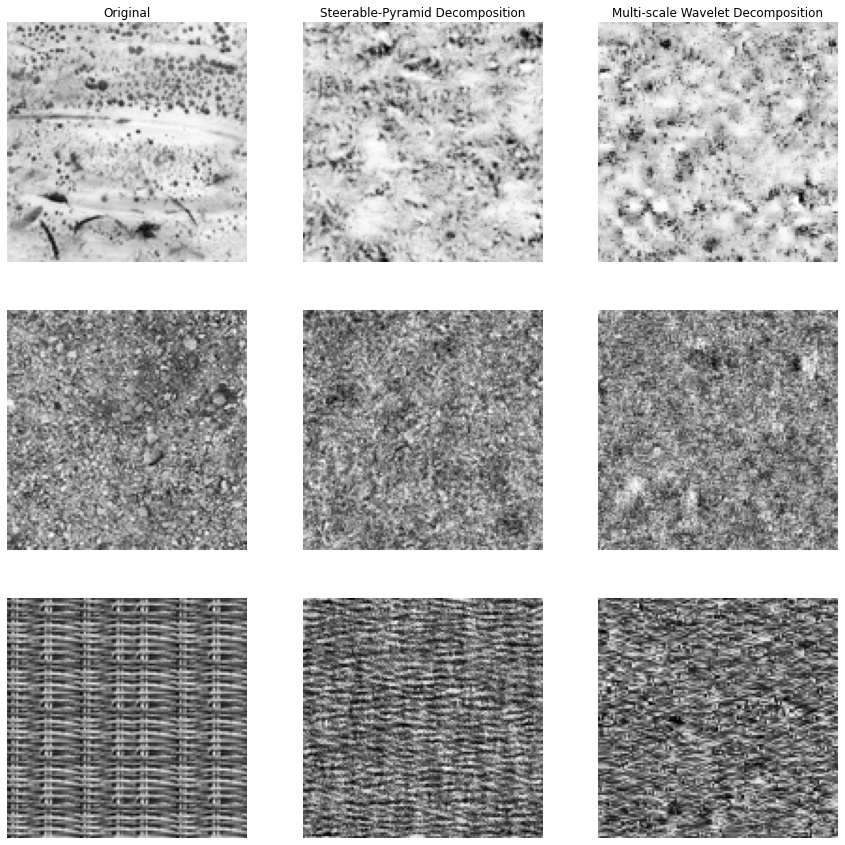

In [21]:
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(15,15))
waves = ['sym3','db3','bior3.1']


for k,texture in enumerate(textures):
    X = rgb2gray(texture)
    ax[k,0].imshow(X,cmap='gray')
    x1,_,_ = pyramid_gray(X,order=3,Nit=10,level=3)
    x2,_,_ = wavepyramid_gray(X,waves,Nit=10,level=3)
    ax[k,1].imshow(x1,cmap='gray')
    ax[k,2].imshow(x2,cmap='gray')
    ax[k,0].axis('off')
    ax[k,1].axis('off')
    ax[k,2].axis('off')

ax[0,0].set_title('Original')
ax[0,1].set_title('Steerable-Pyramid Decomposition')
ax[0,2].set_title('Multi-scale Wavelet Decomposition')

fig.savefig('comparison_gray.png')

**Partie 4 : Synthèses de textures en couleur**


On réalise oréalablement une décomposition en composante principale sur les canaux RGB etla synthèse se fait dans l'espace des composantes principales. En effet, on peut voir que l'essentiel de l'information sur la texture se situe dan la première composante principale.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


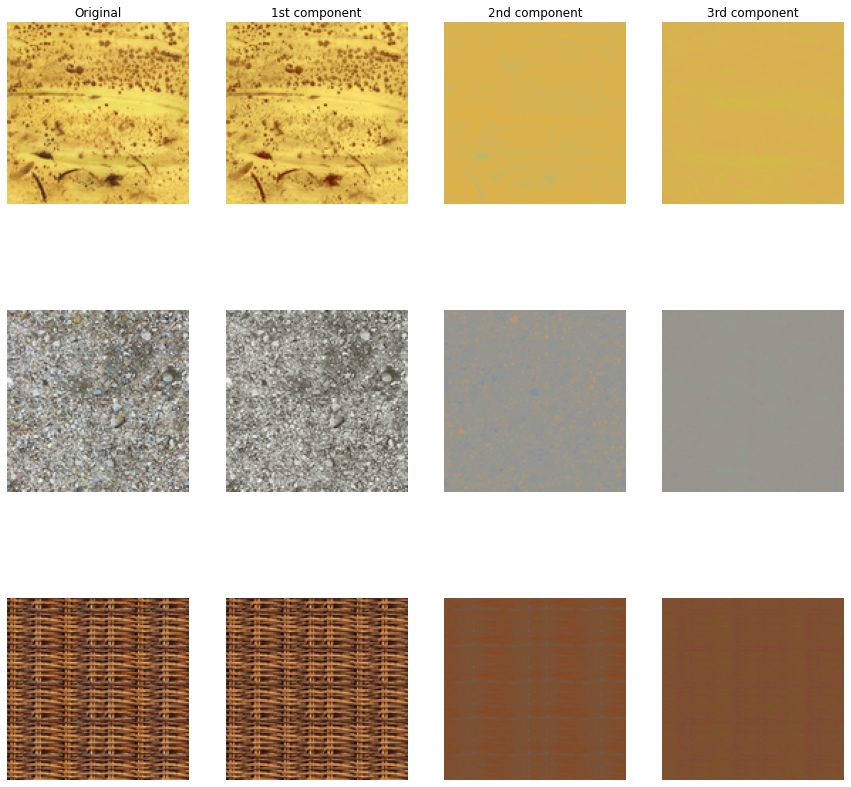

In [22]:
fig,ax = plt.subplots(nrows=3,ncols=4,figsize=(15,15))

for k,texture in enumerate(textures):
    pca = PCA()
    y = texture.reshape((-1,3))
    m = np.mean(y,axis=0)
    x = pca.fit_transform(y-m[None,:])

    for j in range(3):
        z = np.zeros((N*N,3))
        z[:,j] = x[:,j]
        z = (m[None,:]+pca.inverse_transform(z)).reshape((N,N,3))
        ax[k,j+1].imshow(z)
        ax[k,j+1].axis('off')

    ax[k,0].imshow(texture)
    ax[k,0].axis('off')

ax[0,0].set_title('Original')
ax[0,1].set_title('1st component')
ax[0,2].set_title('2nd component')
ax[0,3].set_title('3rd component')

fig.savefig('PCA_color.png')

On adapte donc l'algorithme pour effectuer un synthèse d'image en couleur.

Il y a deux approches différentes :
- ou bien on utilise la projection SW pour effectuer la projection statistique sur l'ensemble des canaux,
- ou bien on utilise une égalisation d'histogramme sur chacun des canaux indépendement.

Cette première fonction implémente la première approche.

In [48]:
def pyramid_color(texture,order=3,Nit=10,level='auto'):
    N,_,c = texture.shape

    ## input-adapted color space where channels are expected to be decorrelated and close to independent
    pca = PCA()
    m = np.mean(texture,axis=(0,1))
    y = texture-m[None,None,:]
    y = pca.fit_transform(y.reshape((-1,c)))
    y = y .reshape((N,N,c))

    ## performing previous algo on each channel, in the PCA color space

    ## white noise
    x = np.random.randn(N,N,c)*np.sqrt(pca.explained_variance_[None,None,:])
    losses = np.zeros(Nit)
    corrections = np.zeros(Nit)

    ## Steerable Pyramid in the frequence domain

    y0 = pt.pyramids.SteerablePyramidFreq(y[:,:,0],height=level,order=order)
    y1 = pt.pyramids.SteerablePyramidFreq(y[:,:,1],height=level,order=order)
    y2 = pt.pyramids.SteerablePyramidFreq(y[:,:,2],height=level,order=order)
  
    for i in range(Nit):    

        x0 = pt.pyramids.SteerablePyramidFreq(x[:,:,0],height=level,order=order)
        x1 = pt.pyramids.SteerablePyramidFreq(x[:,:,1],height=level,order=order)
        x2 = pt.pyramids.SteerablePyramidFreq(x[:,:,2],height=level,order=order)
      
        for w in y0.pyr_coeffs:
            xrec = np.array([x0.pyr_coeffs[w],x1.pyr_coeffs[w],x2.pyr_coeffs[w]]).transpose((1,2,0))
            yrec = np.array([y0.pyr_coeffs[w],y1.pyr_coeffs[w],y2.pyr_coeffs[w]]).transpose((1,2,0))
            
            xrec,l = SWproj(xrec,yrec,e=0.01)  ## statistical constraint through sliced projection
            losses[i] += l
            x0.pyr_coeffs[w] = xrec[:,:,0]
            x1.pyr_coeffs[w] = xrec[:,:,1]
            x2.pyr_coeffs[w] = xrec[:,:,2]

        ## recomposition
        x[:,:,0] = x0.recon_pyr()
        x[:,:,1] = x1.recon_pyr()
        x[:,:,2] = x2.recon_pyr()
        x,corr = SWproj(x,y,e=0.01)
        corrections[i] = corr

      ## coming back to the original color space
    x = (pca.inverse_transform(x.reshape((-1,c)))).reshape((N,N,c))
    x = x+m[None,None,:]
    return x,losses,corrections

Comme pour les images en niveau de gris, on peut utiliser une décomposition en ondelette à la place d'une "steerable-pyramid".

In [39]:
waves = ['bior3.1','sym3']

def wavepyramid_color(texture,waves,Nit=10,level=4):
    N,_,c = texture.shape

    ## input-adapted color space where channels are expected to be decorrelated and close to independent
    pca = PCA()
    m = np.mean(texture,axis=(0,1))
    y = texture-m[None,None,:]
    y = pca.fit_transform(y.reshape((-1,c))).reshape((N,N,c))
    
    ## performing previous algo on each channel, in the PCA color space

    ## white noise
    x = np.sqrt(pca.explained_variance_[None,None,:])*np.random.randn(N,N,c)
    losses = np.zeros(Nit)
    corrections = np.zeros(Nit)

    for i in range(Nit):
        for wave in waves:
            
            ## Multi-scale wavelet decomposition
            ydec = pywt.wavedec2(y,wave,level=level,mode='reflect',axis=(0,1))
            xdec = pywt.wavedec2(x,wave,level=level,mode='reflect',axis=(0,1))
            res = []
            
            ## statistical projection using SWproj
            for l in range(level+1):
                if l==0:
                    yA= ydec[l]
                    xA= xdec[l]
                    xA,rA = SWproj(xA,yA,it=200,e=0.01)
                    losses[i] += rA

                    res.append(xA)
            
                else:
                    yH,yV,yD = ydec[l]
                    xH,xV,xD = xdec[l]
                    xH,rH = SWproj(xH,yH,e=0.01)
                    xV,rV = SWproj(xV,yV,e=0.01)
                    xD,rD = SWproj(xD,yD,e=0.01)
                    losses[i] += rH+rV+rD

                    res.append((xH,xV,xD))
            
            ## recomposition
            x = pywt.waverec2(res,wave,mode='reflect',axis=(0,1))[:,:,:3]
            x,corr = SWproj2(x,y,e=0.01)
            corrections[i] += corr

    x = (pca.inverse_transform(x.reshape((-1,c)))).reshape((N,N,c))
    x = x+m[None,None,:]
    return x,losses,corrections

On constate qu'en utilisant cette méthode, le résultat obtenu n'est qu'une sort de bruit dans la bonne teinte de couleur.

La fonction suivante implémente, la deuxième option. Les résultats sont bien meilleurs.

In [51]:
def pyramid_color2(texture,order=3,Nit=10,level='auto'):
    N,_,c = texture.shape

    # PCA
    pca = PCA()
    m = np.mean(texture,axis=(0,1))
    y = texture-m[None,None,:]
    y = pca.fit_transform(y.reshape((-1,c)))
    y = y .reshape((N,N,c))
    
    # white noise
    x = np.random.randn(N,N,c)*np.sqrt(pca.explained_variance_[None,None,:])
    losses = np.zeros(Nit)
    corrections = np.zeros(Nit)

    # steerable-pyramid decomposition
    y0 = pt.pyramids.SteerablePyramidFreq(y[:,:,0],height=level,order=order)
    y1 = pt.pyramids.SteerablePyramidFreq(y[:,:,1],height=level,order=order)
    y2 = pt.pyramids.SteerablePyramidFreq(y[:,:,2],height=level,order=order)
  
    for i in range(Nit):    

        x0 = pt.pyramids.SteerablePyramidFreq(x[:,:,0],height=level,order=order)
        x1 = pt.pyramids.SteerablePyramidFreq(x[:,:,1],height=level,order=order)
        x2 = pt.pyramids.SteerablePyramidFreq(x[:,:,2],height=level,order=order)
      
        # statistical projection using OTproj on each channel independently
        for w in y0.pyr_coeffs:
            x0.pyr_coeffs[w],l0 = OTproj(x0.pyr_coeffs[w],y0.pyr_coeffs[w])
            x1.pyr_coeffs[w],l1 = OTproj(x1.pyr_coeffs[w],y1.pyr_coeffs[w])
            x2.pyr_coeffs[w],l2 = OTproj(x2.pyr_coeffs[w],y2.pyr_coeffs[w])
            losses[i] += l0+l1+l2

        # recomposition
        x[:,:,0] = x0.recon_pyr()
        x[:,:,1] = x1.recon_pyr()
        x[:,:,2] = x2.recon_pyr()
        x,corr = SWproj(x,y,e=0.01)
        corrections[i] = corr

    x = (pca.inverse_transform(x.reshape((-1,c)))).reshape((N,N,c))
    x = x+m[None,None,:]
    return x,losses,corrections

**Résultats numériques**

On compare visuellement les synthèses données par les deux approches

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


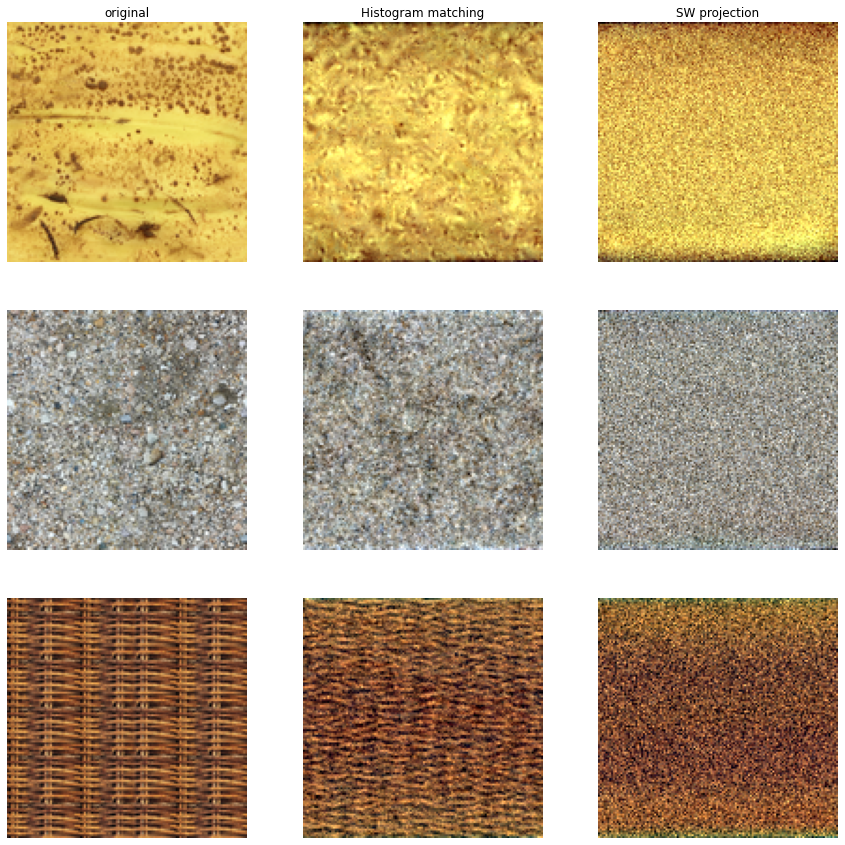

In [52]:
# attention cette cellule peut mettre quelques minutes à être éxecutée 
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(15,15))

for k,texture in enumerate(textures):
    ax[k,0].imshow(texture)
    x2,_,_ = pyramid_color(texture,order=3,Nit=5,level=3)
    x1,_,_ = pyramid_color2(texture,order=3,Nit=5,level=3)
    ax[k,1].imshow(x1)
    ax[k,2].imshow(x2)
    ax[k,0].axis('off')
    ax[k,1].axis('off')
    ax[k,2].axis('off')

ax[0,0].set_title('original')
ax[0,2].set_title('SW projection')
ax[0,1].set_title('Histogram matching')

fig.savefig('comparison_color.png')

**Résultats numériques supplémentaires**

*Convergence du processus de projection*

La question est de savoir est de savoir si l'algorithme converge vers un point fixe du processus de décomposition-projection-itération. On montre ici que la décroissance de la distance de projection est très rapide et semble en effet converger.

(-0.5, 127.5, 127.5, -0.5)

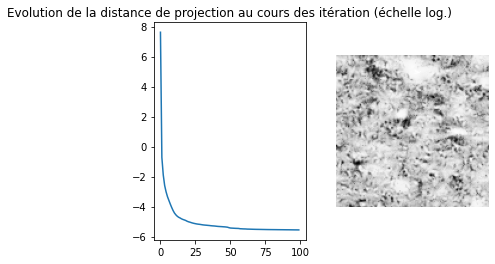

In [63]:
x,losses,corrections = pyramid_gray(rgb2gray(text),Nit=100,order=3,level=3)

fig = plt.figure()

ax = fig.add_subplot(1,2,1)
ax.plot(np.log(losses))
ax.set_title('Evolution de la distance de projection au cours des itération (échelle log.)')

ax = fig.add_subplot(1,2,2)
ax.imshow(x,cmap='gray')
ax.axis('off')

*Statistique d'ordre 2*

En se basant sur la synthèse de texture en couleur, on peut réaliser une synthèse en utilisant des statistiques d'ordre 2.

Pour cela, on empile les valeurs des pixels dans un voisinage dans une 3e dimension. Ensuite on applique une PCA et on ne traite que la composante de variance la plus importante en utlisant une egalisation d'histogramme.

In [98]:
def pyramid_gray_ord2(texture,level=3,order=3,Nit=10):
    
    # stack neighbourhood in 3rd dim
    y = var(texture,pattern)
    N,N,V = y.shape
    
    # PCA
    pca = PCA()
    m = np.mean(y,axis=(0,1))
    y = pca.fit_transform(y.reshape((-1,V))-m[None,:]).reshape((N,N,V))
    
    # decomposition
    ypyr = pt.pyramids.SteerablePyramidFreq(y[:,:,0],height=level,order=order)
    
    # white noise
    x = np.random.randn(N,N)*np.sqrt(pca.explained_variance_[0])
    losses = np.zeros(Nit)
    corrections = np.zeros(Nit)
  
    for i in range(Nit):
        xpyr = pt.pyramids.SteerablePyramidFreq(x,height=level,order=order)
        
        # histogram matching
        for w in xpyr.pyr_coeffs:
            tmp,l = OTproj(xpyr.pyr_coeffs[w],ypyr.pyr_coeffs[w])
            losses[i] += l
            xpyr.pyr_coeffs[w] = tmp
        
        # recomposition
        x = xpyr.recon_pyr()
        x,corr = OTproj(x,y[:,:,0])
        corrections[i] += corr
    
    res = np.zeros((N,N,V))
    res[:,:,0] = x
    res = pca.inverse_transform(res.reshape((-1,V))).reshape((N,N,V))
    res = res + m[None,None,:]
    return res[:,:,0],losses,corrections

On test visuellement sur un exemple. Les résultats ne sont pas vraiment meilleurs que avec les statistiques d'ordre 1.

(-0.5, 127.5, 127.5, -0.5)

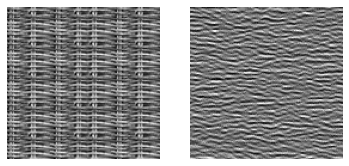

In [102]:
texture = text3
x,losses,corrections = pyramid_gray_ord2(rgb2gray(texture),order=3,level='auto',Nit=10)

fig = plt.figure()

ax = fig.add_subplot(1,2,1)
ax.imshow(rgb2gray(texture),cmap='gray')
ax.axis('off')

ax = fig.add_subplot(1,2,2)
ax.imshow(x,cmap='gray')
ax.axis('off')

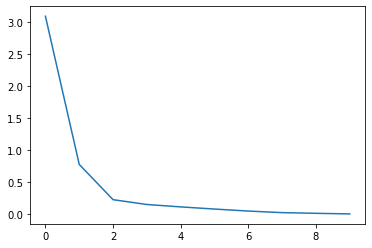

In [103]:
plt.plot(np.log(losses))